In [106]:
# based on ryan's example (Untitled1.ipynb) and etav example (https://etav.github.io/python/scikit_pca.html)
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

%matplotlib inline

### read in grid data

In [107]:
# parameter value lists
T_star = []
logL_star = []
logM_disk = []
logR_disk = []
h_0 = []
logR_in = []
gamma = []
beta = []
logM_env = []
logR_env = []
f_cav = []
ksi = []
loga_max = []
p = []
incl = []

params = [T_star,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]

for i in range(len(params)):
    filename="../grid_metadata/param"+str(i)+".txt"
    with open (filename, 'rb') as fp:
        params[i] = pickle.load(fp) 

# sets - filenames

with open ('../grid_metadata/core518.txt', 'rb') as fp:
    corelog = pickle.load(fp)
with open ('../grid_metadata/core518.txt', 'rb') as fp:
    corelin = pickle.load(fp)
cores=[corelog,corelin]

    
# sets - flux values in log space
with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cubelog = np.array(pickle.load(fp))
with open ('../grid_metadata/cubelin.txt', 'rb') as fp:
    cubelin = np.array(pickle.load(fp))
cubes=[cubelog,cubelin]

labels=["log","lin"]
    
sets=np.linspace(0.,1.,len(cores))
colors= plt.cm.viridis(sets)
    
# x values (wavelengths) - same 500 values for all sets, normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   

### deal with -infs from log transform

In [101]:
# check out -infs

#for i in range(50):
#    if -np.inf in cubes[0][i]:
#        fig,ax=plt.subplots(1,figsize=(12,9))
#        ax.loglog(xvals, 10**cubes[0][i])
#        ax.set_ylim(1.0e-200,1.0e5)
#        plt.ylabel("Flux Density (mJy)",fontsize=16)
#        plt.xlabel("λ (μm)",fontsize=16)
#        plt.show()

In [111]:
# powerlaw cutoff

for i in range(len(cubes[0])):
    if -np.inf in cubes[0][i]:
        a=cubes[0][i].tolist()
        a.reverse()
        ind=len(a)-a.index(-np.inf)
        x1=xvals[ind]
        y1=cubes[0][i][ind]
        for j in range(ind):
            cubes[0][i][j]=(100*(np.log10(xvals[j]/x1)))+y1

/users/eteng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


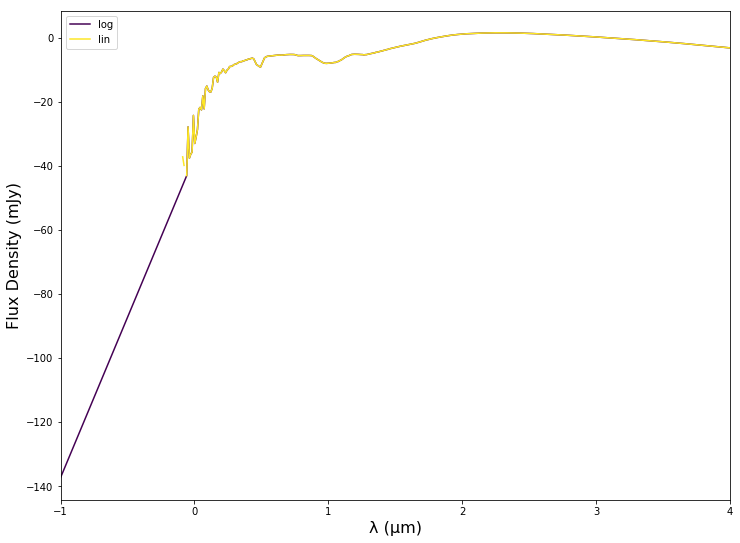

In [112]:
i=6
fig,ax=plt.subplots(1,figsize=(12,9))
ax.plot(np.log10(xvals), cubes[0][i],c=colors[0],label=labels[0])
plt.legend()
plt.xlim(-1,4)
plt.ylabel("Flux Density (mJy)",fontsize=16)
plt.xlabel("λ (μm)",fontsize=16)
plt.show()

### normalizing data

In [118]:
# subtracting from the seds each sample mean

seds_msublog=[]
seds_msublin=[]

seds_msubs=[seds_msublog,seds_msublin]

for i in range(len(cubes)):
    seds_msubs[i] = cubes[i] - np.mean(cubes[i],axis=1)[:,np.newaxis]

### run PCA on mean-subtracted SEDs

In [119]:
t0 = time()

pcalog=[]
pcalin=[]

pcas=[pcalog,pcalin]

for i in (range(len(pcas))):
    pcas[i] = PCA(n_components=40).fit(seds_msubs[i])
print("done in %0.3fs" % (time() - t0))

done in 0.030s


In [120]:
eigensedslog=[]
eigensedslin=[]
eigenseds=[eigensedslog,eigensedslin]

for i in range(len(cubes)):
    eigenseds[i]=pcas[i].components_
    eigenseds=np.array(eigenseds)

### look at eigenSEDs

In [121]:
def show_SED(fluxvals):
    fig,ax=plt.subplots(1,figsize=(12,9))
    ax.plot(np.log10(xvals), fluxvals)
    #ax.set_ylim(-6,5)
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

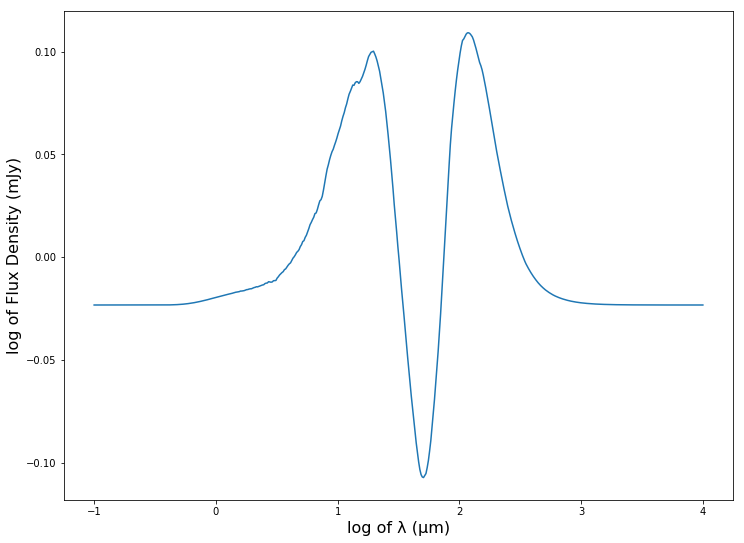

In [139]:
show_SED(eigenseds[1][2])

### variance explained

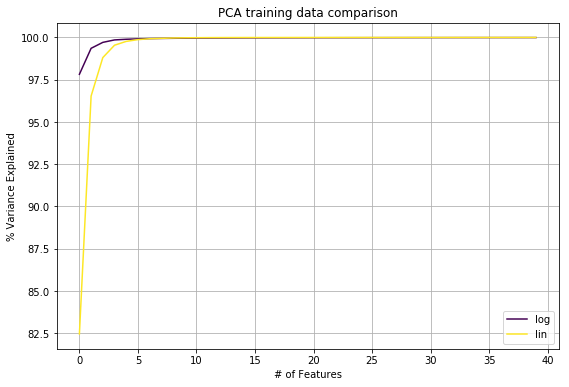

In [142]:
fig,ax=plt.subplots(1,figsize=(9,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA training data comparison')
#plt.ylim(95,100.)
plt.style.context('seaborn-whitegrid')
for i in range(len(cubes)):
    ax.plot(np.cumsum(pcas[i].explained_variance_ratio_)*100,label=str(labels[i]),c=colors[i])
plt.legend()
plt.grid()
plt.show()

### compare log-spaced SEDs reconstructed with increasing number of components against pdspy SED

In [160]:
def sedcomp(model,ds,ncomp=40, nfeat=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp+1],eigenseds[ds][0:ncomp+1,0:nfeat]) \
            +pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model])    
    if ds==0:
        ax.plot(np.log10(xvals)[0:nfeat], reconst, c='b',label="reconstructed SED, ncomp="+str(ncomp+1))
    if ds==1:
        ax.plot(np.log10(xvals)[0:nfeat], np.log10(reconst), c='b',label="reconstructed SED, ncomp="+str(ncomp+1))
    ax.plot(np.log10(xvals)[0:nfeat], cubes[0][model][0:nfeat], c='black',label="pdspy SED")
    plt.legend()
    plt.title("reconstructed SED of "+labels[ds]+" model #"+str(model)+" against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

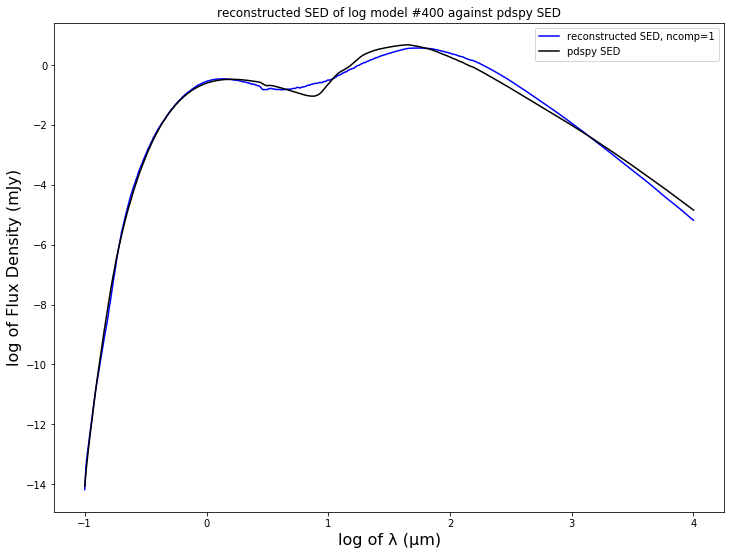

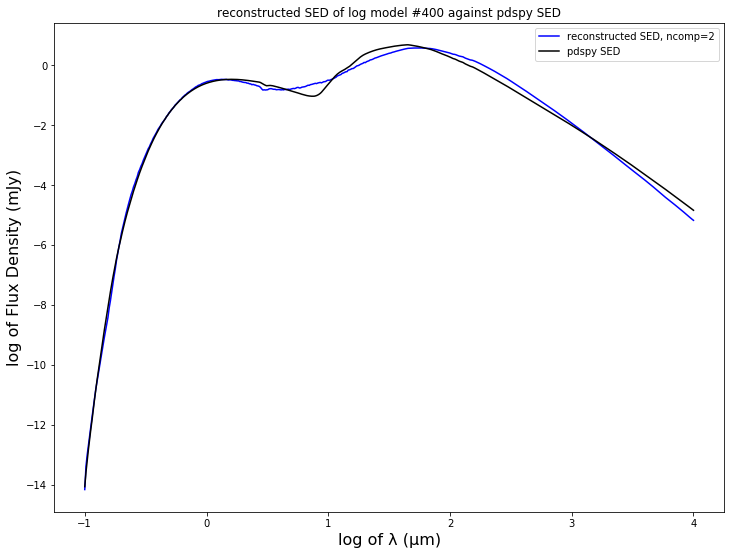

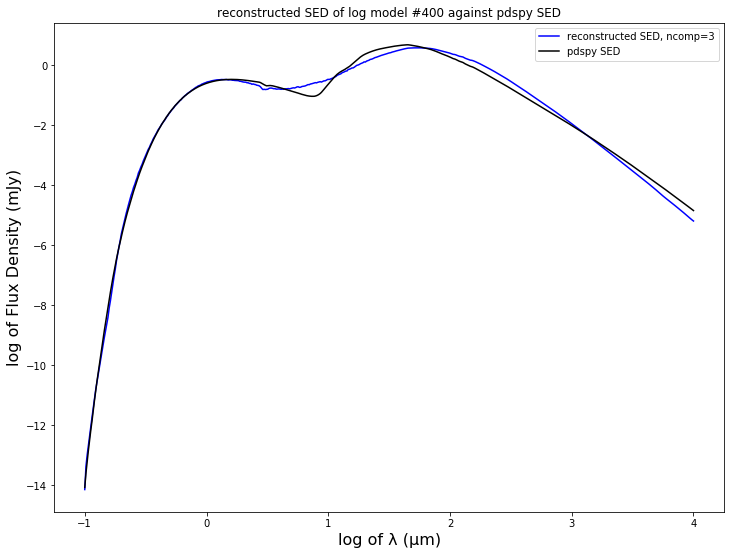

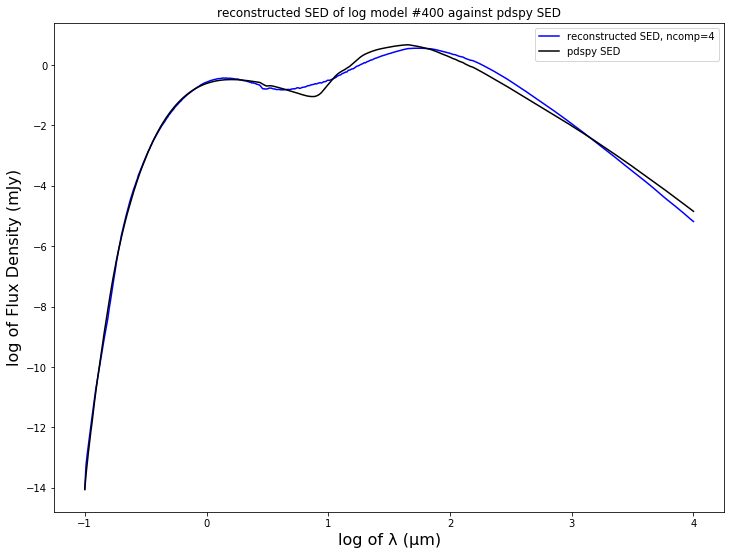

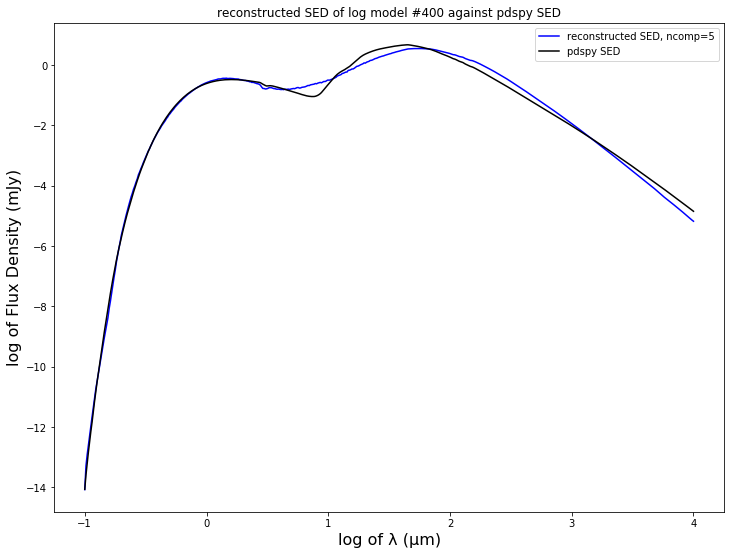

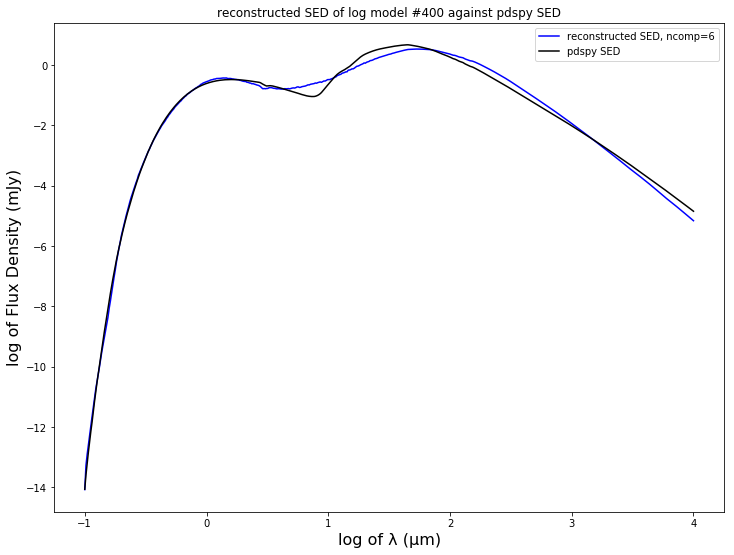

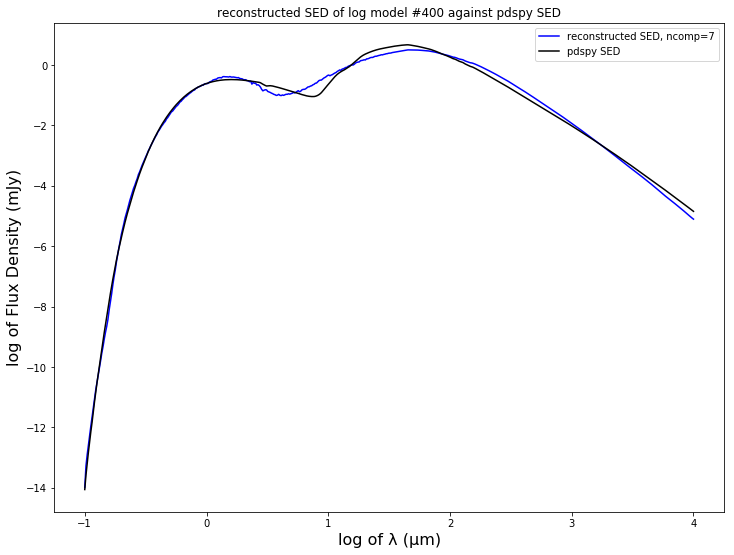

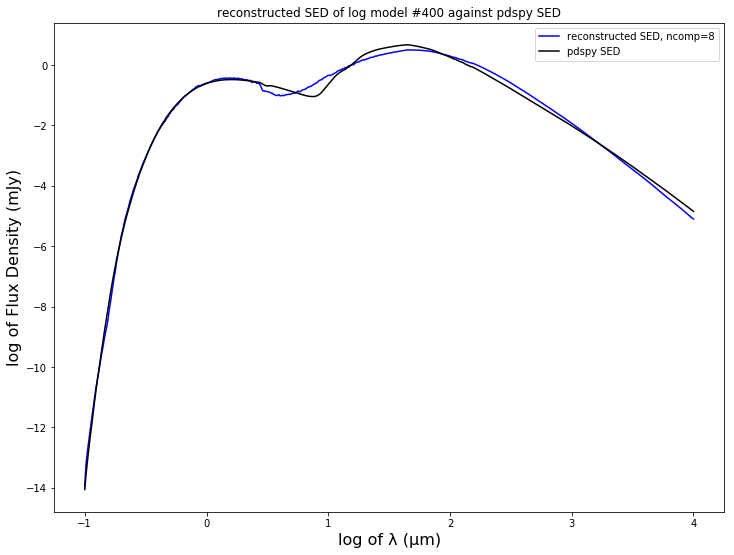

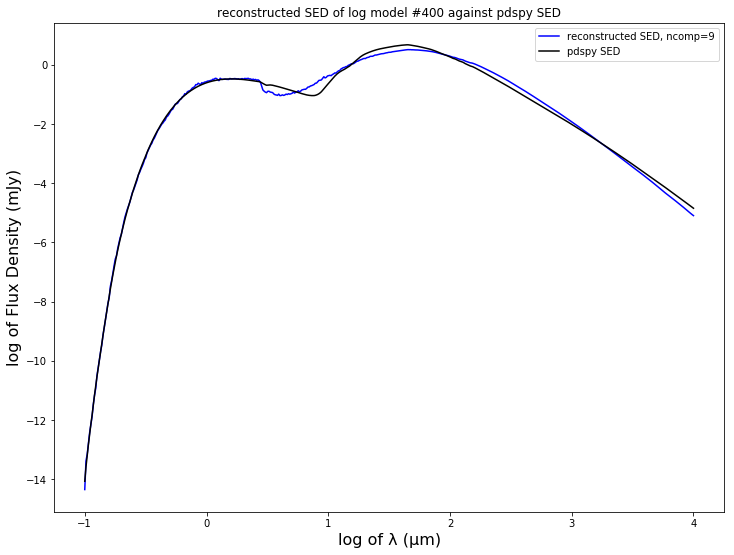

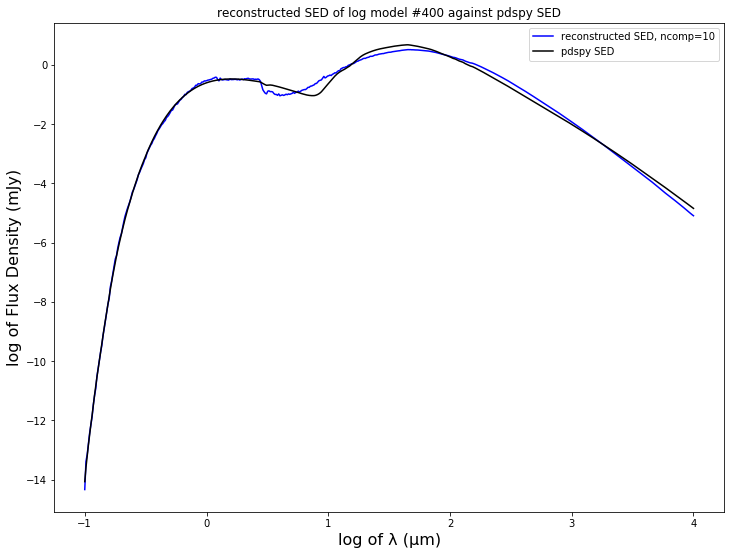

In [163]:
for m in range(10):
    sedcomp(400,0,ncomp=m)

In [147]:
def sedcomp_anim_log(model,ds,ncomp=40,nfeat=500):
    
    fig,ax= plt.subplots(figsize=(12,9))
    ax.plot(np.log10(xvals)[0:nfeat], cubes[0][model][0:nfeat], c='black',label="pdspy SED")
        
    coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1)) 
    reconst=[]
    for j in range(ncomp):
        reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[ds][0:j+1,0:nfeat]) +\
                           pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model]))
            
    if ds==0:
        line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')
    if ds==1:
        line, = ax.plot(np.log10(xvals)[0:nfeat], np.log10(reconst[0]), c='b')
    
    def animate(i):
        label="number of components = {0}".format(int(i//1))
        if ds==0:
            line.set_ydata(reconst[int(i//1)])
        if ds==1:
            line.set_ydata(np.log10(reconst[int(i//1)]))
        ax.set_xlabel("log of λ (μm)",fontsize=16)
        ax.set_ylabel("log of Flux Density (mJy)",fontsize=16)
        ax.set_title("reconstructed SED of "+labels[ds]+" model #"+str(model)+" against pdspy SED, ncomp="+str(int(i//1)+1))
        return line,ax

    anim=FuncAnimation(fig,animate,frames=np.arange(0,ncomp,0.25),interval=1)
    anim.save("../visualization/comp_space/sedcomp_"+labels[ds]+"_m"+str(model)+"_nc"+str(ncomp)+".gif", dpi=72, writer="imagemagick")

/users/eteng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/users/eteng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


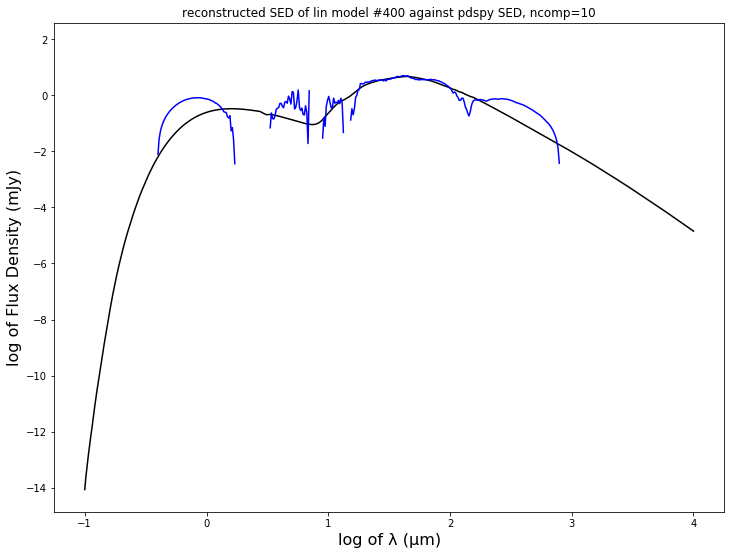

In [165]:
sedcomp_anim_log(400,1,ncomp=10)

### compare log-spaced residuals of SEDs reconstructed with increasing number of components

In [ ]:
def residcomp(model,ds,ncomp=40,nfeat=500):
    
    interval=np.linspace(0.1,1.,ncomp)
    colors= plt.cm.viridis(interval)
    
    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(ncomp):
        coeffs=pcas[ds].transform(seds_msubs[ds][i].reshape(1,-1))
        reconst=np.dot(coeffs[0][0:m+1],eigenseds[ds][0:m+1,0:nfeat]) \
                +pcas[ds].mean_[0:nfeat]+np.mean(cubes[ds][model])
        resids = reconst-(cubes[ds][i][0:nfeat]) # log flux space residuals
        # resids = 10**reconst-10**(cubes[ds][i][0:nfeat]) # normal flux space residuals
        ax.plot(np.log10(xvals)[0:nfeat],resids, c=colors[m],label="ncomp="+str(m+1)) 
    plt.legend()
    plt.title("log-space residuals of reconst. SEDs of "+str(sizes[ds])+" model #"+str(i)+\
              ", by number of components")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

In [ ]:
residcomp(100,3,ncomp=10)